# Discrete Optimal Transport
This notebook explores the calculation of optimal transport between two sets of points using discrete methods.

In [197]:
#!pip install pot ipywidgets
#!pip install ipywidgets
#!pip install jupyterlab_widgets

In [198]:
import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
import ot
# from utils import generate_data, process_ansur_data
# from ipywidgets import interact, Dropdown

In [222]:
def generate_data(n, distribution="uniform", l=1):
    """
    Generates random data according to the specified distribution in dimension 2.
    
    Args:
        n (int): Number of points to generate.
        distribution (str): The type of distribution (default is "uniform").
        l (float): Radius for the uniform distribution (only relevant for "uniform").
    
    Returns:
        np.array: Array of generated data.
    """
    d = 2  # Dimension (fixed here to 2)
    
    if distribution == "normal":
        # Parameters for the normal distribution (mean and standard deviation)
        mean = 0  # Default mean
        std = 1   # Default standard deviation
        return np.random.normal(loc=mean, scale=std, size=(n, d))
        
    elif distribution == "uniform":
        num_theta = 5*int(np.sqrt(n-1))
        theta = np.linspace (0 , 2 * np.pi , num_theta )
        rad = np.linspace(0.01, 1, int( (n-1)/num_theta )+1 )
        
        z = np . array ([[0 , 0]])
        for r in rad:
            for t in theta:
                x = r * np . cos (t)
                y = r * np . sin (t)
                z = np . vstack ((z , np . column_stack ((x , y)) ))
                
        return z[:n]

    elif distribution == "banana":
        # Generation of coordinates X and Phi
        X = -1 + 2 * np.random.rand(n)  # X between -1 and 1
        Phi = 2 * np.pi * np.random.rand(n)  # Phi between 0 and 2π
        
        # Calculation of radii R
        R = 0.2 * np.random.rand(n) * (1 + (1 - np.abs(X)) / 2)  # Radius adjusted according to X
        
        # Calculation of coordinates y according to the "banana" distribution
        z = np.column_stack((X + R * np.cos(Phi), X**2 + R * np.sin(Phi)))
        
        return z
    
    
    else:
        raise ValueError("Supported distributions: 'normal', 'uniform', 'banana'")



def process_ansur_data(file_path):
    """
    Transforms and cleans ANSUR data (Male or Female).
    
    Args:
        file_path (str): Path to the CSV file containing ANSUR data.
    
    Returns:
        np.array: Cleaned data array with columns for height (cm) and weight (kg).
    """
    # Read the ANSUR dataset
    ansur = pd.read_csv(file_path, sep=",", encoding="ISO-8859-1")
    
    # Select and rename relevant columns
    data = ansur[["Heightin", "weightkg"]].rename(columns={"Heightin": "Height (inches)", "weightkg": "Weight (kg)"})
    
    # Convert height from inches to centimeters
    data["Height (inches)"] *= 2.54
    data.rename(columns={"Height (inches)": "Height (cm)"}, inplace=True)
    
    # Convert weight from pounds to kilograms (divide by 10)
    data["Weight (kg)"] /= 10
    
    # Remove the last row (possible outlier)
    data = data.iloc[:-1]
    
    return np.array(data)



def univariate_median(z):
    """
    Calculates the median of the two coordinates (x and y) in the dataset z.

    Args:
        z (np.array): Array of shape (n, 2) representing 2D data points.

    Returns:
        tuple: A tuple containing the median of the x and y coordinates.
    """
    # Compute the median of the x and y coordinates separately
    median_x = np.median(z[:, 0])
    median_y = np.median(z[:, 1])
    
    # Return the results as a tuple
    return float(median_x), float(median_y)



def plot_data(datasets):
    """
    Plots a list of datasets, each represented as a 2D array.
    
    Args:
        datasets (list): List of 2D numpy arrays, where each dataset is of shape (n, 2).
    """
    assert len(datasets) > 0, "The dataset list must contain at least one dataset."
    
    num_datasets = len(datasets)
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']  # Extended color palette
    num_columns = min(3, num_datasets)  # Up to 3 plots per row
    num_rows = (num_datasets + num_columns - 1) // num_columns  # Calculate rows to fit all plots

    # Create a figure with adequate size
    plt.figure(figsize=(5 * num_columns, 5 * num_rows))
    plt.suptitle("Visualization of Distributions", fontweight="bold", fontsize=16)
    
    for i, data in enumerate(datasets):
        pl.subplot(num_rows, num_columns, i + 1)  # Position subplot
        pl.scatter(data[:, 0], data[:, 1], color=colors[i % len(colors)], alpha=0.7)
        pl.title(f'Dataset {i + 1}', fontsize=12)
        pl.axis('equal')  # Ensure equal scaling on both axes
        pl.grid(True, linestyle='--', alpha=0.6)  # Optional grid for better visualization

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
    plt.show()



def plot_transport(X, Y, transport_matrix=None, title="Optimal Transport"):
    """
    Visualizes the optimal transport between two sets of points X and Y.
    
    Args:
        X (np.array): Source set of points, shape (n, d).
        Y (np.array): Target set of points, shape (m, d).
        transport_matrix (np.array, optional): Transport matrix indicating weights of connections.
        title (str): Title for the plot.
    """
    # Validate inputs
    assert X.shape[1] == Y.shape[1], "Source and target points must have the same dimensionality."
    assert X.shape[1] == 2, "This function only supports 2D points for visualization."

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], label="Source Points", color='blue', s=50, alpha=0.8)
    plt.scatter(Y[:, 0], Y[:, 1], label="Target Points", color='red', s=50, alpha=0.8)

    # Add transport connections if transport_matrix is provided
    if transport_matrix is not None:
        n, m = transport_matrix.shape
        assert n == len(X) and m == len(Y), "Transport matrix dimensions must match the number of points in X and Y."
        
        # Plot lines weighted by the transport matrix
        for i in range(n):
            for j in range(m):
                if transport_matrix[i, j] > 0:
                    plt.plot(
                        [X[i, 0], Y[j, 0]], 
                        [X[i, 1], Y[j, 1]], 
                        color='gray', 
                        alpha=0.5,  # Adjust transparency by weight  * transport_matrix[i, j]
                        linewidth=1
                    )
    
    # Add plot details
    plt.title(title, fontsize=14, fontweight="bold")
    plt.axis('equal')  # Ensure equal scaling
    plt.grid(linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()



def plot_quantile(X, Y, transport_matrix, quantile):
    """
    Plots the optimal transport quantiles between the source (unit circle) and target (banana distribution).

    Args:
        X (np.array): Source distribution (n, 2), e.g., unit circle.
        Y (np.array): Target distribution (m, 2), e.g., banana distribution.
        transport_matrix (np.array): Optimal transport matrix (n, m).
        quantile (float): The desired quantile radius on the unit circle.
    """
    # Find indices of points within the desired quantile on the source distribution
    indices_source = np.where(np.sqrt(X[:, 0]**2 + X[:, 1]**2) <= quantile)[0]
    
    # Extract transport links for these source points
    transport_links = np.argwhere(transport_matrix[indices_source, :] > 0)
    
    # Plot source points (unit circle) with quantile highlight
    plt.figure(figsize=(16, 6))
    plt.suptitle("Optimal Transport of Quantiles Between the Two Distributions", fontweight="bold")
    
    # Plot source distribution
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], color="b", label="Source Data", s=50, alpha=0.8)
    plt.scatter(X[indices_source, 0], X[indices_source, 1], color="r", label=f"Quantile {quantile}")
    plt.title("Source Distribution")
    plt.legend()
    plt.axis("equal")
    
    # Plot target distribution
    plt.subplot(1, 2, 2)
    plt.scatter(Y[:, 0], Y[:, 1], color="b", label="Target Data", s=50, alpha=0.8)
    
    # Highlight corresponding target points
    indices_target = transport_links[:, 1]  # Extract target indices from transport links
    plt.scatter(Y[indices_target, 0], Y[indices_target, 1], color="r", label=f"Target Points for Quantile {quantile}")
    plt.title("Target Distribution")
    plt.legend()
    plt.axis("equal")
    
    plt.show()


def optimal_transport_median(X, Y, transport_matrix):
    """
    Computes the median of points via optimal transport between two sets X and Y.
    
    Args:
        X (np.array): Source set of points (n, d).
        Y (np.array): Target set of points (m, d).
        transport_matrix (np.array): The optimal transport matrix between X and Y.
    
    Returns:
        tuple: The median obtained via optimal transport (coordinates of a point in Y).
    """
    
    # Extracting the transport links for the first point in X (index 0)
    transport_link = np.argwhere(transport_matrix[0, :] > 0)

    # Return the target points from Y that are linked via the transport matrix
    median_point = Y[transport_link[0][0]] # Extracting the target points indices and returning the corresponding points
    return float(median_point[0]), float(median_point[1])

In [223]:
optimal_transport_median(z,Z,gamma)

(177.8, 83.7)

# Data Generation

## Loading the Data

In [224]:
# Data generation
banana_distribution = generate_data(501, 'banana')

ansur_male = process_ansur_data('ANSUR II MALE Public.csv')
ansur_female = process_ansur_data('ANSUR II FEMALE Public.csv')
    
# Storing in a dictionary for easy selection
datasets = {
    'Banana Distribution': banana_distribution,
    'ANSUR Male II': ansur_male,
    'ANSUR Female II': ansur_female
}

## Selection of the target distribution

In [225]:
# Prompt the user to select the target distribution
def select_dataset():
    print("Please select a distribution from the following options:")
    for i, key in enumerate(datasets.keys(), 1):
        print(f"{i}. {key}")

    choice = int(input("Enter the corresponding number: ")) - 1
    if 0 <= choice < len(datasets):
        selected = list(datasets.keys())[choice]
        print(f"Selected distribution: {selected}")
        return datasets[selected]
    else:
        print("Invalid choice.")
        return None

# Update Z
Z = select_dataset()

Please select a distribution from the following options:
1. Banana Distribution
2. ANSUR Male II
3. ANSUR Female II


Enter the corresponding number:  3


Selected distribution: ANSUR Female II


## Generation of the source distribution

In [226]:
z = generate_data(501, "uniform")  # Source (loi uniforme par défaut)

### Median of the source distribution

In [227]:
# Median on the 2 distinct coordinates
print(f'Empirical median (x, y): {univariate_median(z)}')

Empirical median (x, y): (0.00014410476677557366, 0.005450418408609857)


The median should be (0,0)

## Plotting the source and target distributions

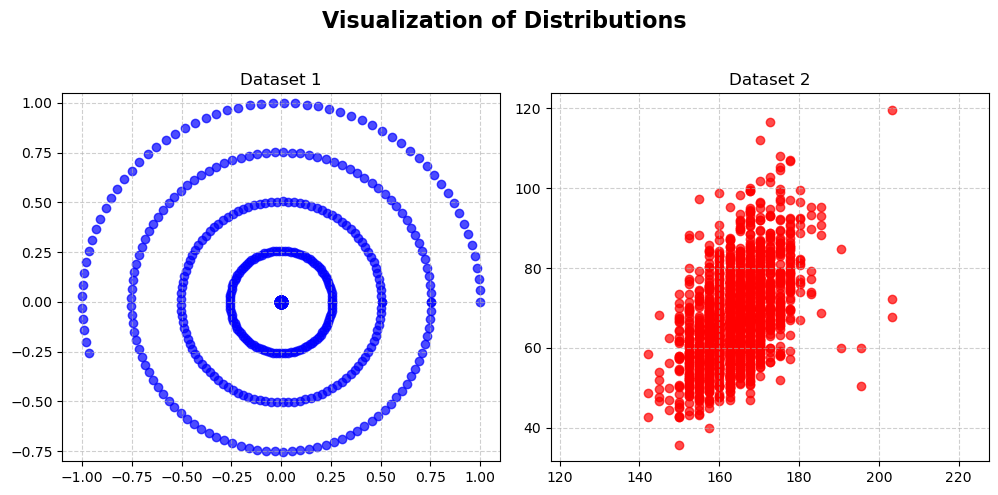

In [228]:
plot_data([z,Z])

# Optimal Transport

## Computation of Optimal Transport

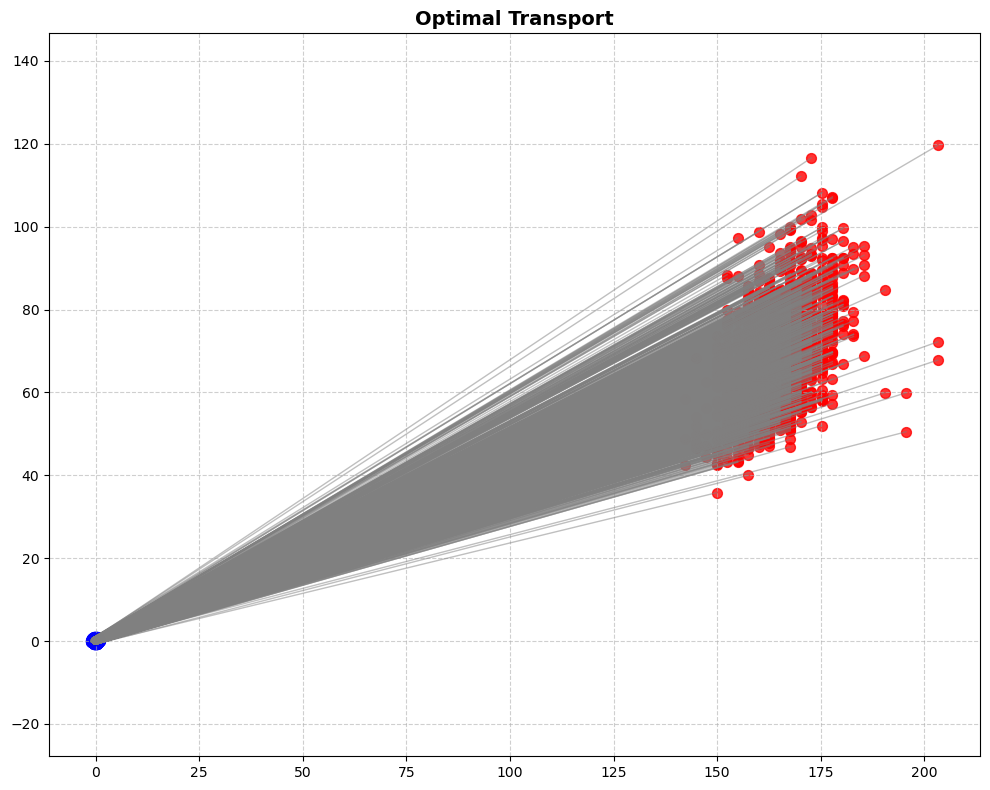

In [229]:
# Uniform weights for the distributions
a, b = np.ones(len(z)) / len(z), np.ones(len(Z)) / len(Z)

# Cost matrix (Euclidean distances between points)
M = ot.dist(z, Z)

# Solve the optimal transport problem using the EMD algorithm
gamma = ot.emd(a, b, M)

# Plot the transport plan between the source and target distributions
plot_transport(z, Z, gamma)

## Plotting quantiles 0, 0.2, and 0.6

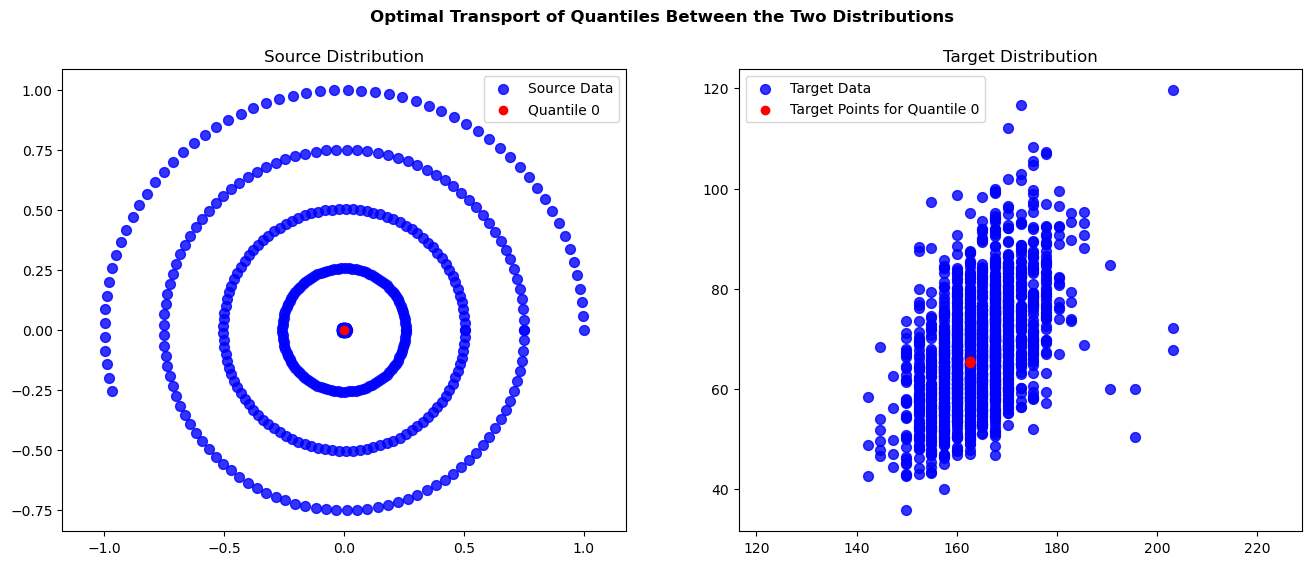

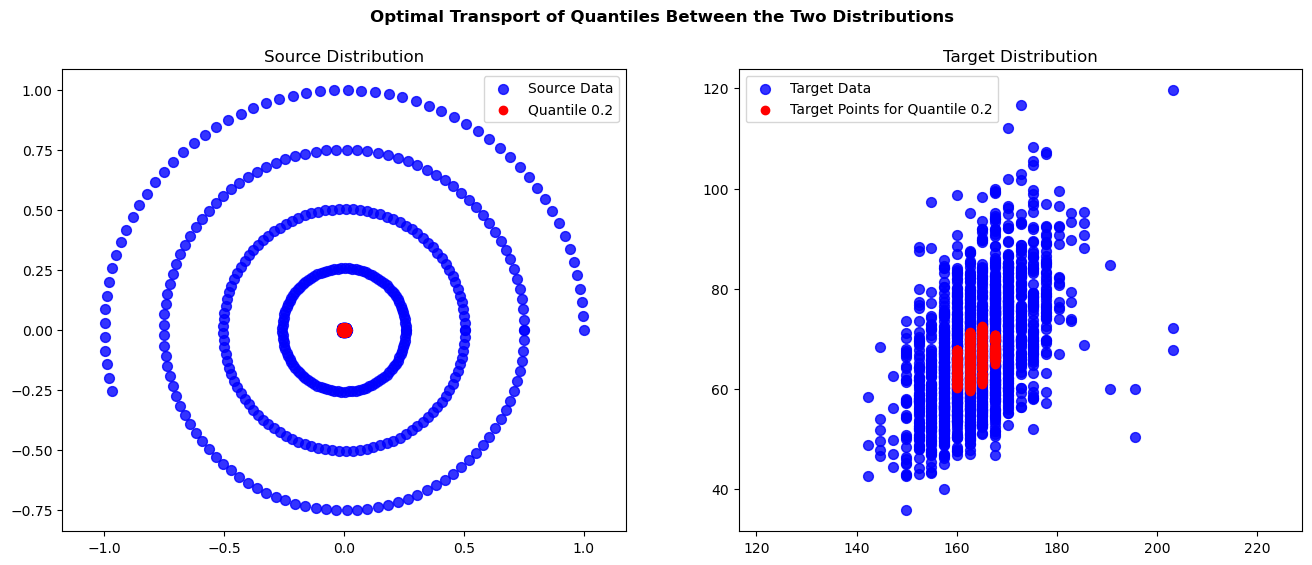

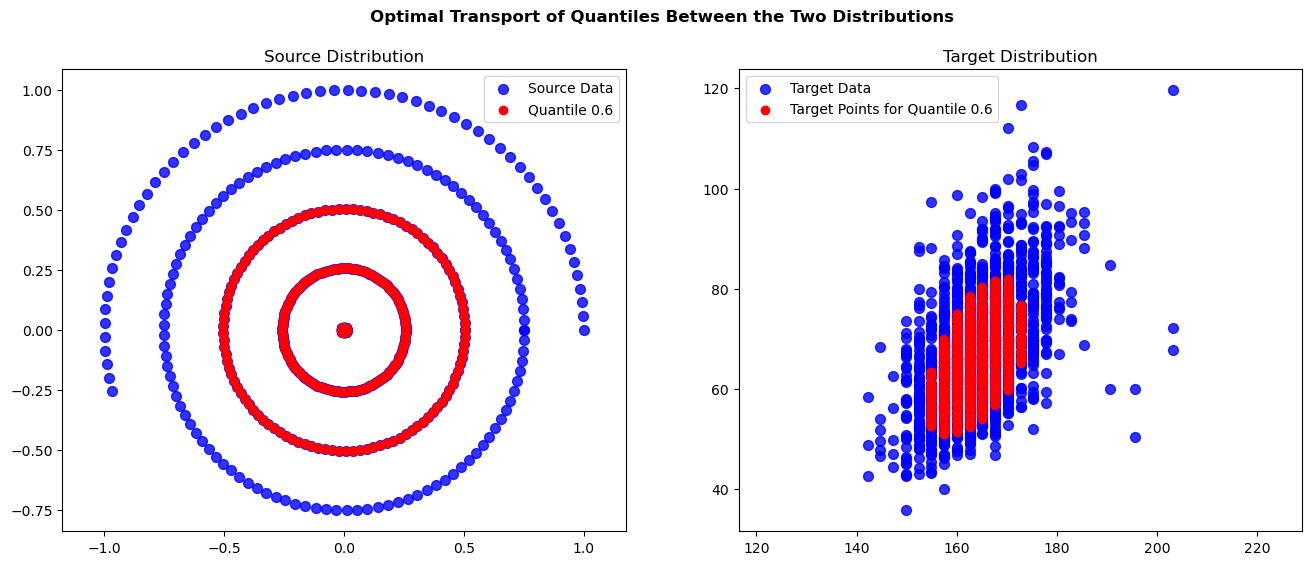

In [230]:
# Median
plot_quantile(z, Z, gamma, 0)

# Quantile 0.2
plot_quantile(z, Z, gamma, 0.2)

# Quantile 0.6
plot_quantile(z, Z, gamma, 0.6)

## Comparison of Medians

In [231]:
# Median on the 2 distinct coordinates
print(f'Empirical median (x, y): {univariate_median(Z)}')

# Median by optimal transport
print(f'Optimal transport median (x, y): {optimal_transport_median(z, Z, gamma)}')

Empirical median (x, y): (162.56, 66.8)
Optimal transport median (x, y): (162.56, 65.3)


# Conclusion
In this notebook, we generated two sets of points, calculated the optimal transport between them, and determined the median obtained by optimal transport. The results were visualized using graphs.